In [1]:
import numpy as np
import tenpy
import time
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
from tenpy.algorithms import dmrg

In [2]:
def example_DMRG_tf_ising_infinite_S_xi_scaling(g):
    model_params = dict(L=2, J=1., g=g, bc_MPS='infinite', conserve='best', verbose=1)
    M = TFIChain(model_params)
    product_state = ["up"] * M.lat.N_sites
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
        'start_env': 10,
        'mixer': False,
        #  'mixer_params': {'amplitude': 1.e-3, 'decay': 5., 'disable_after': 50},
        'trunc_params': {
            'chi_max': 5,
            'svd_min': 1.e-10
        },
        'max_E_err': 1.e-9,
        'max_S_err': 1.e-6,
        'update_env': 0,
        'verbose': 1
    }

    chi_list = np.arange(7, 31, 2)
    s_list = []
    xi_list = []
    eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)

    for chi in chi_list:

        t0 = time.time()
        eng.reset_stats(
        )  # necessary if you for example have a fixed numer of sweeps, if you don't set this you option your simulation stops after initial number of sweeps!
        eng.trunc_params['chi_max'] = chi
        ##   DMRG Calculation    ##
        print("Start IDMRG CALCULATION")
        eng.run()
        eng.engine_params['mixer'] = None
        psi.canonical_form()

        ##   Calculating bond entropy and correlation length  ##
        s_list.append(np.mean(psi.entanglement_entropy()))
        xi_list.append(psi.correlation_length())

        print(chi,
              time.time() - t0,
              np.mean(psi.expectation_value(M.H_bond)),
              s_list[-1],
              xi_list[-1],
              flush=True)
        tenpy.tools.optimization.optimize(3)  # quite some speedup for small chi

        print("SETTING NEW BOND DIMENSION")

    return s_list, xi_list

In [3]:
def fit_plot_central_charge(s_list, xi_list, filename):
    """Plot routine in order to determine the cental charge."""
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit

    def fitFunc(Xi, c, a):
        return (c / 6) * np.log(Xi) + a

    Xi = np.array(xi_list)
    S = np.array(s_list)
    LXi = np.log(Xi)  # Logarithm of the correlation length xi

    fitParams, fitCovariances = curve_fit(fitFunc, Xi, S)

    # Plot fitting parameter and covariances
    print('c =', fitParams[0], 'a =', fitParams[1])
    print('Covariance Matrix', fitCovariances)

    # plot the data as blue circles
    plt.errorbar(LXi,
                 S,
                 fmt='o',
                 c='blue',
                 ms=5.5,
                 markerfacecolor='white',
                 markeredgecolor='blue',
                 markeredgewidth=1.4)
    # plot the fitted line
    plt.plot(LXi,
             fitFunc(Xi, fitParams[0], fitParams[1]),
             linewidth=1.5,
             c='black',
             label='fit c={c:.2f}'.format(c=fitParams[0]))

    plt.xlabel(r'$\log{\,}\xi_{\chi}$', fontsize=16)
    plt.ylabel(r'$S$', fontsize=16)
    plt.legend(loc='lower right', borderaxespad=0., fancybox=True, shadow=True, fontsize=16)
    plt.savefig(filename)

In [4]:
s_list, xi_list = example_DMRG_tf_ising_infinite_S_xi_scaling(g=1)

parameter 'verbose'=1 for TFIChain
parameter 'lattice'='Chain' for TFIChain
parameter 'bc_MPS'='infinite' for TFIChain
parameter 'conserve'='best' for TFIChain
TFIChain: set conserve to parity
parameter 'L'=2 for TFIChain
parameter 'J'=1.0 for TFIChain
parameter 'g'=1 for TFIChain
parameter 'verbose'=1 for Sweep
parameter 'trunc_params'={'chi_max': 5, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........
Start IDMRG CALCULATION
parameter 'max_E_err'=1e-09 for DMRG
parameter 'max_S_err'=1e-06 for DMRG
parameter 'update_env'=0 for DMRG
parameter 'mixer'=False for Sweep
sweep 10, age = 160
Energy = -1.2732084331860776, S = 0.5565885704390419, norm_err = 1.7e-03
Current memory usage 98.3 MB, time elapsed: 0.6 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 6.2158e-07, max_E_trunc = 3.7471e-06
MPS bond dimensions: [7, 7]
sweep 20, age = 240
Energy = -1.2732185733771217, S = 0.5932360013956479, norm_err = 4.5e-04
Current m

sweep 130, age = 1840
Energy = -1.2732300165422430, S = 0.6485540555206143, norm_err = 2.9e-05
Current memory usage 101.6 MB, time elapsed: 8.9 s
Delta E = 1.2903e-11, Delta S = 1.0101e-06 (per sweep)
max_trunc_err = 6.4226e-07, max_E_trunc = 4.0360e-06
MPS bond dimensions: [9, 9]
sweep 140, age = 1920
Energy = -1.2732300164731782, S = 0.6485594815911313, norm_err = 2.9e-05
Current memory usage 101.6 MB, time elapsed: 9.5 s
Delta E = 6.9065e-12, Delta S = 5.4261e-07 (per sweep)
max_trunc_err = 6.4230e-07, max_E_trunc = 4.0362e-06
MPS bond dimensions: [9, 9]
norm_tol=1.00e-05 not reached, norm_err=2.88e-05
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.88e-05
Call psi.canonical_form()


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 140 sweeps.
total size = 1920, maximum chi = 9
9 10.050215005874634 -1.2732299642993217 0.6483000379003206 18.639538776818558
SETTING NEW BOND DIMENSION
Start IDMRG CALCULATION
sweep 10, age = 2000
Energy = -1.2732364320972920, S = 0.6626093868208986, norm_err = 2.8e-04
Current memory usage 101.8 MB, time elapsed: 0.8 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 8.8981e-08, max_E_trunc = 5.5853e-07
MPS bond dimensions: [11, 11]
sweep 20, age = 2080
Energy = -1.2732367129468685, S = 0.6740172295469324, norm_err = 2.1e-04
Current memory usage 101.8 MB, time elapsed: 1.5 s
Delta E = -2.8085e-08, Delta S = 1.1408e-03 (per sweep)
max_trunc_err = 1.1920e-07, max_E_trunc = 7.4237e-07
MPS bond dimensions: [11, 11]
sweep 30, age = 2160
Energy = -1.2732368182523714, S = 0.6817160559465405, norm_err = 1.5e-04
Current memory usage 101.8 MB, time elapsed: 2.1 s
Delta E = -1.0531e-08, Delta S = 7.6988e-04 (per sweep)
max_trunc_err = 1.3331e-07, max_E_trunc = 8.3037e

11 14.897470235824585 -1.2732368640876786 0.6978252308943821 34.766241432407554
SETTING NEW BOND DIMENSION
Start IDMRG CALCULATION
sweep 10, age = 3680
Energy = -1.2732378317380153, S = 0.6914604758187410, norm_err = 7.7e-05
Current memory usage 102.1 MB, time elapsed: 0.9 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 5.9411e-08, max_E_trunc = 3.6109e-07
MPS bond dimensions: [13, 13]
sweep 20, age = 3760
Energy = -1.2732379264766678, S = 0.6987195892499118, norm_err = 1.0e-04
Current memory usage 102.1 MB, time elapsed: 1.6 s
Delta E = -9.4739e-09, Delta S = 7.2591e-04 (per sweep)
max_trunc_err = 6.9932e-08, max_E_trunc = 4.2376e-07
MPS bond dimensions: [13, 13]
sweep 30, age = 3840
Energy = -1.2732379708320423, S = 0.7042401538648465, norm_err = 9.2e-05
Current memory usage 102.2 MB, time elapsed: 2.2 s
Delta E = -4.4355e-09, Delta S = 5.5206e-04 (per sweep)
max_trunc_err = 7.6121e-08, max_E_trunc = 4.6030e-07
MPS bond dimensions: [13, 13]
sweep 40, age = 3920
Energy = -1

sweep 240, age = 5520
Energy = -1.2732380147277809, S = 0.7205673526841190, norm_err = 4.5e-06
Current memory usage 102.2 MB, time elapsed: 16.1 s
Delta E = 1.2847e-12, Delta S = 1.4830e-06 (per sweep)
max_trunc_err = 9.3191e-08, max_E_trunc = 5.6051e-07
MPS bond dimensions: [13, 13]
sweep 250, age = 5600
Energy = -1.2732380147210733, S = 0.7205785930838560, norm_err = 4.4e-06
Current memory usage 102.2 MB, time elapsed: 16.8 s
Delta E = 6.7075e-13, Delta S = 1.1240e-06 (per sweep)
max_trunc_err = 9.3203e-08, max_E_trunc = 5.6059e-07
MPS bond dimensions: [13, 13]
sweep 260, age = 5680
Energy = -1.2732380147133426, S = 0.7205871128463266, norm_err = 4.4e-06
Current memory usage 102.2 MB, time elapsed: 17.5 s
Delta E = 7.7307e-13, Delta S = 8.5198e-07 (per sweep)
max_trunc_err = 9.3212e-08, max_E_trunc = 5.6064e-07
MPS bond dimensions: [13, 13]
DMRG finished after 260 sweeps.
total size = 5680, maximum chi = 13
13 17.947608470916748 -1.2732380102049157 0.7206346035017039 45.2322730256948

sweep 200, age = 7280
Energy = -1.2732387389439737, S = 0.7431012767885876, norm_err = 1.6e-04
Current memory usage 102.2 MB, time elapsed: 23.0 s
Delta E = -9.5497e-12, Delta S = 5.9378e-06 (per sweep)
max_trunc_err = 4.9002e-08, max_E_trunc = 3.1249e-07
MPS bond dimensions: [15, 15]
sweep 210, age = 7360
Energy = -1.2732387391249631, S = 0.7431399598954792, norm_err = 2.2e-04
Current memory usage 102.2 MB, time elapsed: 23.9 s
Delta E = -1.8099e-11, Delta S = 3.8683e-06 (per sweep)
max_trunc_err = 4.9069e-08, max_E_trunc = 3.1289e-07
MPS bond dimensions: [15, 15]
sweep 220, age = 7440
Energy = -1.2732387390976783, S = 0.7431873411155394, norm_err = 1.7e-04
Current memory usage 102.2 MB, time elapsed: 24.9 s
Delta E = 2.7285e-12, Delta S = 4.7381e-06 (per sweep)
max_trunc_err = 4.9078e-08, max_E_trunc = 3.1296e-07
MPS bond dimensions: [15, 15]
sweep 230, age = 7520
Energy = -1.2732387394121361, S = 0.7432163495446159, norm_err = 2.6e-04
Current memory usage 102.2 MB, time elapsed: 25.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


15 27.21466588973999 -1.2732386773013222 0.7463943402299439 68.01104685878802
SETTING NEW BOND DIMENSION
Start IDMRG CALCULATION
sweep 10, age = 7680
Energy = -1.2732390241080793, S = 0.7429927396494296, norm_err = 2.5e-04
Current memory usage 102.2 MB, time elapsed: 1.1 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.6786e-08, max_E_trunc = 1.0805e-07
MPS bond dimensions: [17, 17]
sweep 20, age = 7760
Energy = -1.2732390454953020, S = 0.7470013110882330, norm_err = 8.3e-05
Current memory usage 102.2 MB, time elapsed: 1.6 s
Delta E = -2.1387e-09, Delta S = 4.0086e-04 (per sweep)
max_trunc_err = 1.8686e-08, max_E_trunc = 1.2035e-07
MPS bond dimensions: [17, 17]
sweep 30, age = 7840
Energy = -1.2732390563578520, S = 0.7505424956860276, norm_err = 7.2e-05
Current memory usage 102.2 MB, time elapsed: 2.0 s
Delta E = -1.0863e-09, Delta S = 3.5412e-04 (per sweep)
max_trunc_err = 2.0206e-08, max_E_trunc = 1.2995e-07
MPS bond dimensions: [17, 17]
sweep 40, age = 7920
Energy = -1.2

sweep 240, age = 9520
Energy = -1.2732390762419072, S = 0.7699265183067208, norm_err = 2.9e-06
Current memory usage 102.2 MB, time elapsed: 11.4 s
Delta E = 3.0695e-12, Delta S = 1.1294e-05 (per sweep)
max_trunc_err = 2.6443e-08, max_E_trunc = 1.6987e-07
MPS bond dimensions: [17, 17]
sweep 250, age = 9600
Energy = -1.2732390762178056, S = 0.7700224586740072, norm_err = 2.5e-06
Current memory usage 102.2 MB, time elapsed: 11.9 s
Delta E = 2.4102e-12, Delta S = 9.5940e-06 (per sweep)
max_trunc_err = 2.6473e-08, max_E_trunc = 1.7006e-07
MPS bond dimensions: [17, 17]
sweep 260, age = 9680
Energy = -1.2732390761957504, S = 0.7701040166054915, norm_err = 2.2e-06
Current memory usage 102.2 MB, time elapsed: 12.3 s
Delta E = 2.2055e-12, Delta S = 8.1558e-06 (per sweep)
max_trunc_err = 2.6499e-08, max_E_trunc = 1.7023e-07
MPS bond dimensions: [17, 17]
sweep 270, age = 9760
Energy = -1.2732390761750594, S = 0.7701733437457603, norm_err = 1.9e-06
Current memory usage 102.4 MB, time elapsed: 12.8 

sweep 70, age = 11280
Energy = -1.2732392016571339, S = 0.7761037697202212, norm_err = 1.4e-05
Current memory usage 102.4 MB, time elapsed: 4.0 s
Delta E = -1.7144e-11, Delta S = 6.6209e-05 (per sweep)
max_trunc_err = 1.9079e-08, max_E_trunc = 1.2127e-07
MPS bond dimensions: [19, 19]
sweep 80, age = 11360
Energy = -1.2732392017712755, S = 0.7767101348221650, norm_err = 1.3e-05
Current memory usage 102.4 MB, time elapsed: 4.4 s
Delta E = -1.1414e-11, Delta S = 6.0637e-05 (per sweep)
max_trunc_err = 1.9243e-08, max_E_trunc = 1.2230e-07
MPS bond dimensions: [19, 19]
sweep 90, age = 11440
Energy = -1.2732392018492646, S = 0.7771950689290796, norm_err = 1.2e-05
Current memory usage 102.4 MB, time elapsed: 4.9 s
Delta E = -7.7989e-12, Delta S = 4.8493e-05 (per sweep)
max_trunc_err = 1.9373e-08, max_E_trunc = 1.2311e-07
MPS bond dimensions: [19, 19]
sweep 100, age = 11520
Energy = -1.2732392018915561, S = 0.7776222292696653, norm_err = 9.3e-06
Current memory usage 102.4 MB, time elapsed: 5.3 

sweep 300, age = 13120
Energy = -1.2732392018233440, S = 0.7800683117716767, norm_err = 1.0e-06
Current memory usage 102.4 MB, time elapsed: 14.4 s
Delta E = 4.5475e-14, Delta S = 1.9615e-06 (per sweep)
max_trunc_err = 2.0116e-08, max_E_trunc = 1.2778e-07
MPS bond dimensions: [19, 19]
sweep 310, age = 13200
Energy = -1.2732392018174323, S = 0.7800850869922886, norm_err = 1.0e-06
Current memory usage 102.4 MB, time elapsed: 14.8 s
Delta E = 5.9117e-13, Delta S = 1.6775e-06 (per sweep)
max_trunc_err = 2.0120e-08, max_E_trunc = 1.2781e-07
MPS bond dimensions: [19, 19]
sweep 320, age = 13280
Energy = -1.2732392018183418, S = 0.7800994870207143, norm_err = 9.8e-07
Current memory usage 102.4 MB, time elapsed: 15.2 s
Delta E = -9.0949e-14, Delta S = 1.4400e-06 (per sweep)
max_trunc_err = 2.0124e-08, max_E_trunc = 1.2783e-07
MPS bond dimensions: [19, 19]
sweep 330, age = 13360
Energy = -1.2732392018169776, S = 0.7801118438748084, norm_err = 9.5e-07
Current memory usage 102.4 MB, time elapsed: 

sweep 170, age = 14880
Energy = -1.2732393092264829, S = 0.7938009651473193, norm_err = 7.1e-06
Current memory usage 102.4 MB, time elapsed: 14.3 s
Delta E = 9.0949e-14, Delta S = 2.8504e-05 (per sweep)
max_trunc_err = 1.3817e-08, max_E_trunc = 8.7934e-08
MPS bond dimensions: [21, 21]
sweep 180, age = 14960
Energy = -1.2732393092246639, S = 0.7940472941223806, norm_err = 6.5e-06
Current memory usage 102.4 MB, time elapsed: 14.7 s
Delta E = 1.8190e-13, Delta S = 2.4633e-05 (per sweep)
max_trunc_err = 1.3860e-08, max_E_trunc = 8.8206e-08
MPS bond dimensions: [21, 21]
sweep 190, age = 15040
Energy = -1.2732393092173879, S = 0.7942651503506353, norm_err = 5.6e-06
Current memory usage 102.4 MB, time elapsed: 15.2 s
Delta E = 7.2760e-13, Delta S = 2.1786e-05 (per sweep)
max_trunc_err = 1.3899e-08, max_E_trunc = 8.8465e-08
MPS bond dimensions: [21, 21]
sweep 200, age = 15120
Energy = -1.2732393092060192, S = 0.7944565632261225, norm_err = 5.1e-06
Current memory usage 102.4 MB, time elapsed: 1

sweep 400, age = 16720
Energy = -1.2732393090841470, S = 0.7957321978632279, norm_err = 1.6e-06
Current memory usage 102.4 MB, time elapsed: 24.4 s
Delta E = -4.5475e-13, Delta S = 1.4304e-06 (per sweep)
max_trunc_err = 1.4161e-08, max_E_trunc = 9.0138e-08
MPS bond dimensions: [21, 21]
sweep 410, age = 16800
Energy = -1.2732393090823280, S = 0.7957447797316977, norm_err = 1.6e-06
Current memory usage 102.4 MB, time elapsed: 24.8 s
Delta E = 1.8190e-13, Delta S = 1.2582e-06 (per sweep)
max_trunc_err = 1.4163e-08, max_E_trunc = 9.0164e-08
MPS bond dimensions: [21, 21]
sweep 420, age = 16880
Energy = -1.2732393090732330, S = 0.7957558198984866, norm_err = 1.6e-06
Current memory usage 102.4 MB, time elapsed: 25.2 s
Delta E = 9.0949e-13, Delta S = 1.1040e-06 (per sweep)
max_trunc_err = 1.4165e-08, max_E_trunc = 9.0182e-08
MPS bond dimensions: [21, 21]
sweep 430, age = 16960
Energy = -1.2732393090768710, S = 0.7957655295064953, norm_err = 1.6e-06
Current memory usage 102.4 MB, time elapsed: 

sweep 190, age = 18480
Energy = -1.2732393941710143, S = 0.8144188482182555, norm_err = 1.2e-05
Current memory usage 102.4 MB, time elapsed: 9.1 s
Delta E = -4.1837e-12, Delta S = 4.8917e-05 (per sweep)
max_trunc_err = 8.1720e-09, max_E_trunc = 5.2303e-08
MPS bond dimensions: [23, 23]
sweep 200, age = 18560
Energy = -1.2732393941896589, S = 0.8148722849102199, norm_err = 1.1e-05
Current memory usage 102.4 MB, time elapsed: 9.6 s
Delta E = -1.8645e-12, Delta S = 4.5344e-05 (per sweep)
max_trunc_err = 8.2146e-09, max_E_trunc = 5.2580e-08
MPS bond dimensions: [23, 23]
sweep 210, age = 18640
Energy = -1.2732393942037561, S = 0.8152822385863705, norm_err = 1.0e-05
Current memory usage 102.4 MB, time elapsed: 10.0 s
Delta E = -1.4097e-12, Delta S = 4.0995e-05 (per sweep)
max_trunc_err = 8.2535e-09, max_E_trunc = 5.2823e-08
MPS bond dimensions: [23, 23]
sweep 220, age = 18720
Energy = -1.2732393942110320, S = 0.8156615433043286, norm_err = 9.3e-06
Current memory usage 102.4 MB, time elapsed: 

sweep 420, age = 20320
Energy = -1.2732393940432303, S = 0.8190638919565576, norm_err = 2.4e-06
Current memory usage 102.4 MB, time elapsed: 19.3 s
Delta E = 4.5475e-13, Delta S = 6.5773e-06 (per sweep)
max_trunc_err = 8.6132e-09, max_E_trunc = 5.5101e-08
MPS bond dimensions: [23, 23]
sweep 430, age = 20400
Energy = -1.2732393940386828, S = 0.8191241768284434, norm_err = 2.3e-06
Current memory usage 102.4 MB, time elapsed: 19.8 s
Delta E = 4.5475e-13, Delta S = 6.0285e-06 (per sweep)
max_trunc_err = 8.6190e-09, max_E_trunc = 5.5144e-08
MPS bond dimensions: [23, 23]
sweep 440, age = 20480
Energy = -1.2732393940364091, S = 0.8191794799887442, norm_err = 2.2e-06
Current memory usage 102.4 MB, time elapsed: 20.2 s
Delta E = 2.2737e-13, Delta S = 5.5303e-06 (per sweep)
max_trunc_err = 8.6243e-09, max_E_trunc = 5.5170e-08
MPS bond dimensions: [23, 23]
sweep 450, age = 20560
Energy = -1.2732393940232214, S = 0.8192301822810899, norm_err = 2.1e-06
Current memory usage 102.4 MB, time elapsed: 2

DMRG finished after 640 sweeps.
total size = 22080, maximum chi = 23
23 29.696377754211426 -1.2732393936071418 0.8200336436033876 151.79887157892125
SETTING NEW BOND DIMENSION
Start IDMRG CALCULATION
sweep 10, age = 22160
Energy = -1.2732393768737893, S = 0.8021160194134072, norm_err = 1.4e-04
Current memory usage 102.9 MB, time elapsed: 1.2 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.9787e-09, max_E_trunc = 1.2380e-08
MPS bond dimensions: [25, 25]
sweep 20, age = 22240
Energy = -1.2732394233544255, S = 0.8036596781913313, norm_err = 4.9e-05
Current memory usage 102.9 MB, time elapsed: 1.8 s
Delta E = -4.6481e-09, Delta S = 1.5437e-04 (per sweep)
max_trunc_err = 2.9436e-09, max_E_trunc = 1.8306e-08
MPS bond dimensions: [25, 25]
sweep 30, age = 22320
Energy = -1.2732394296854181, S = 0.8056814448740814, norm_err = 2.6e-05
Current memory usage 102.9 MB, time elapsed: 2.2 s
Delta E = -6.3310e-10, Delta S = 2.0218e-04 (per sweep)
max_trunc_err = 3.4767e-09, max_E_trunc = 2

sweep 230, age = 23920
Energy = -1.2732394421600475, S = 0.8275814566204667, norm_err = 1.1e-05
Current memory usage 102.9 MB, time elapsed: 11.4 s
Delta E = -7.1395e-12, Delta S = 4.8958e-05 (per sweep)
max_trunc_err = 5.3072e-09, max_E_trunc = 3.2509e-08
MPS bond dimensions: [25, 25]
sweep 240, age = 24000
Energy = -1.2732394422173456, S = 0.8280238609051366, norm_err = 1.0e-05
Current memory usage 102.9 MB, time elapsed: 11.9 s
Delta E = -5.7298e-12, Delta S = 4.4240e-05 (per sweep)
max_trunc_err = 5.3346e-09, max_E_trunc = 3.2684e-08
MPS bond dimensions: [25, 25]
sweep 250, age = 24080
Energy = -1.2732394422755533, S = 0.8284427431985948, norm_err = 9.6e-06
Current memory usage 102.9 MB, time elapsed: 12.3 s
Delta E = -5.8208e-12, Delta S = 4.1888e-05 (per sweep)
max_trunc_err = 5.3603e-09, max_E_trunc = 3.2833e-08
MPS bond dimensions: [25, 25]
sweep 260, age = 24160
Energy = -1.2732394423092046, S = 0.8288248139213267, norm_err = 8.6e-06
Current memory usage 102.9 MB, time elapsed

sweep 460, age = 25760
Energy = -1.2732394425052007, S = 0.8326717045231781, norm_err = 1.9e-06
Current memory usage 102.9 MB, time elapsed: 22.3 s
Delta E = 0.0000e+00, Delta S = 8.6810e-06 (per sweep)
max_trunc_err = 5.6234e-09, max_E_trunc = 3.4430e-08
MPS bond dimensions: [25, 25]
sweep 470, age = 25840
Energy = -1.2732394425029270, S = 0.8327524875554055, norm_err = 1.7e-06
Current memory usage 102.9 MB, time elapsed: 22.8 s
Delta E = 2.2737e-13, Delta S = 8.0783e-06 (per sweep)
max_trunc_err = 5.6285e-09, max_E_trunc = 3.4473e-08
MPS bond dimensions: [25, 25]
sweep 480, age = 25920
Energy = -1.2732394425056555, S = 0.8328273821955128, norm_err = 1.6e-06
Current memory usage 102.9 MB, time elapsed: 23.3 s
Delta E = -2.7285e-13, Delta S = 7.4895e-06 (per sweep)
max_trunc_err = 5.6332e-09, max_E_trunc = 3.4495e-08
MPS bond dimensions: [25, 25]
sweep 490, age = 26000
Energy = -1.2732394425056555, S = 0.8328970955272430, norm_err = 1.5e-06
Current memory usage 102.9 MB, time elapsed: 

sweep 690, age = 27600
Energy = -1.2732394424920130, S = 0.8335999553011373, norm_err = 4.0e-07
Current memory usage 102.9 MB, time elapsed: 33.4 s
Delta E = 5.4570e-13, Delta S = 1.6025e-06 (per sweep)
max_trunc_err = 5.6817e-09, max_E_trunc = 3.4786e-08
MPS bond dimensions: [25, 25]
sweep 700, age = 27680
Energy = -1.2732394425102029, S = 0.8336148284083580, norm_err = 3.9e-07
Current memory usage 102.9 MB, time elapsed: 33.9 s
Delta E = -1.8190e-12, Delta S = 1.4873e-06 (per sweep)
max_trunc_err = 5.6826e-09, max_E_trunc = 3.4765e-08
MPS bond dimensions: [25, 25]
sweep 710, age = 27760
Energy = -1.2732394425092934, S = 0.8336286677804710, norm_err = 3.8e-07
Current memory usage 102.9 MB, time elapsed: 34.4 s
Delta E = 9.0949e-14, Delta S = 1.3839e-06 (per sweep)
max_trunc_err = 5.6835e-09, max_E_trunc = 3.4808e-08
MPS bond dimensions: [25, 25]
sweep 720, age = 27840
Energy = -1.2732394425029270, S = 0.8336415023172624, norm_err = 3.7e-07
Current memory usage 102.9 MB, time elapsed: 

sweep 150, age = 29360
Energy = -1.2732394614777149, S = 0.8274755942683154, norm_err = 2.7e-05
Current memory usage 102.9 MB, time elapsed: 9.7 s
Delta E = -4.2292e-11, Delta S = 1.1693e-04 (per sweep)
max_trunc_err = 3.6790e-09, max_E_trunc = 2.2621e-08
MPS bond dimensions: [27, 27]
sweep 160, age = 29440
Energy = -1.2732394618496983, S = 0.8285791361113367, norm_err = 2.5e-05
Current memory usage 102.9 MB, time elapsed: 10.2 s
Delta E = -3.7198e-11, Delta S = 1.1035e-04 (per sweep)
max_trunc_err = 3.7301e-09, max_E_trunc = 2.2941e-08
MPS bond dimensions: [27, 27]
sweep 170, age = 29520
Energy = -1.2732394621734784, S = 0.8295948611296177, norm_err = 2.3e-05
Current memory usage 102.9 MB, time elapsed: 10.6 s
Delta E = -3.2378e-11, Delta S = 1.0157e-04 (per sweep)
max_trunc_err = 3.7775e-09, max_E_trunc = 2.3276e-08
MPS bond dimensions: [27, 27]
sweep 180, age = 29600
Energy = -1.2732394624417793, S = 0.8305525262530873, norm_err = 2.2e-05
Current memory usage 102.9 MB, time elapsed:

sweep 380, age = 31200
Energy = -1.2732394639861013, S = 0.8405524028159348, norm_err = 5.6e-06
Current memory usage 102.9 MB, time elapsed: 20.4 s
Delta E = -1.9099e-12, Delta S = 2.4460e-05 (per sweep)
max_trunc_err = 4.2940e-09, max_E_trunc = 2.6463e-08
MPS bond dimensions: [27, 27]
sweep 390, age = 31280
Energy = -1.2732394639951963, S = 0.8407807940464032, norm_err = 5.2e-06
Current memory usage 102.9 MB, time elapsed: 20.8 s
Delta E = -9.0949e-13, Delta S = 2.2839e-05 (per sweep)
max_trunc_err = 4.3050e-09, max_E_trunc = 2.6557e-08
MPS bond dimensions: [27, 27]
sweep 400, age = 31360
Energy = -1.2732394639942868, S = 0.8409948544362675, norm_err = 4.9e-06
Current memory usage 102.9 MB, time elapsed: 21.3 s
Delta E = 9.0949e-14, Delta S = 2.1406e-05 (per sweep)
max_trunc_err = 4.3153e-09, max_E_trunc = 2.6637e-08
MPS bond dimensions: [27, 27]
sweep 410, age = 31440
Energy = -1.2732394640106577, S = 0.8411949004679378, norm_err = 4.5e-06
Current memory usage 102.9 MB, time elapsed:

sweep 610, age = 33040
Energy = -1.2732394640179336, S = 0.8433429644363499, norm_err = 1.2e-06
Current memory usage 103.2 MB, time elapsed: 30.6 s
Delta E = 4.5475e-13, Delta S = 5.3508e-06 (per sweep)
max_trunc_err = 4.4289e-09, max_E_trunc = 2.7358e-08
MPS bond dimensions: [27, 27]
sweep 620, age = 33120
Energy = -1.2732394640206621, S = 0.8433930987529960, norm_err = 1.1e-06
Current memory usage 103.2 MB, time elapsed: 31.1 s
Delta E = -2.7285e-13, Delta S = 5.0134e-06 (per sweep)
max_trunc_err = 4.4313e-09, max_E_trunc = 2.7394e-08
MPS bond dimensions: [27, 27]
sweep 630, age = 33200
Energy = -1.2732394640224811, S = 0.8434400265800197, norm_err = 1.0e-06
Current memory usage 103.2 MB, time elapsed: 31.5 s
Delta E = -1.8190e-13, Delta S = 4.6928e-06 (per sweep)
max_trunc_err = 4.4336e-09, max_E_trunc = 2.7379e-08
MPS bond dimensions: [27, 27]
sweep 640, age = 33280
Energy = -1.2732394640215716, S = 0.8434839835347365, norm_err = 9.6e-07
Current memory usage 103.2 MB, time elapsed:

sweep 840, age = 34880
Energy = -1.2732394639970153, S = 0.8439578677300661, norm_err = 3.0e-07
Current memory usage 103.2 MB, time elapsed: 41.0 s
Delta E = 8.1855e-13, Delta S = 1.1868e-06 (per sweep)
max_trunc_err = 4.4588e-09, max_E_trunc = 2.7590e-08
MPS bond dimensions: [27, 27]
sweep 850, age = 34960
Energy = -1.2732394639942868, S = 0.8439689812414051, norm_err = 2.9e-07
Current memory usage 103.2 MB, time elapsed: 41.5 s
Delta E = 2.7285e-13, Delta S = 1.1114e-06 (per sweep)
max_trunc_err = 4.4593e-09, max_E_trunc = 2.7583e-08
MPS bond dimensions: [27, 27]
sweep 860, age = 35040
Energy = -1.2732394640152052, S = 0.8439793852896812, norm_err = 2.9e-07
Current memory usage 103.2 MB, time elapsed: 41.9 s
Delta E = -2.0918e-12, Delta S = 1.0404e-06 (per sweep)
max_trunc_err = 4.4598e-09, max_E_trunc = 2.7539e-08
MPS bond dimensions: [27, 27]
sweep 870, age = 35120
Energy = -1.2732394640106577, S = 0.8439891451633628, norm_err = 2.8e-07
Current memory usage 103.2 MB, time elapsed: 

sweep 190, age = 36640
Energy = -1.2732394785034558, S = 0.8468585271059508, norm_err = 8.0e-06
Current memory usage 103.2 MB, time elapsed: 9.2 s
Delta E = -3.8199e-12, Delta S = 3.6512e-05 (per sweep)
max_trunc_err = 3.3826e-09, max_E_trunc = 2.1966e-08
MPS bond dimensions: [29, 29]
sweep 200, age = 36720
Energy = -1.2732394785170982, S = 0.8471871916007809, norm_err = 7.7e-06
Current memory usage 103.2 MB, time elapsed: 9.6 s
Delta E = -1.3642e-12, Delta S = 3.2866e-05 (per sweep)
max_trunc_err = 3.3965e-09, max_E_trunc = 2.2061e-08
MPS bond dimensions: [29, 29]
sweep 210, age = 36800
Energy = -1.2732394785425640, S = 0.8475110357264257, norm_err = 7.4e-06
Current memory usage 103.2 MB, time elapsed: 10.1 s
Delta E = -2.5466e-12, Delta S = 3.2384e-05 (per sweep)
max_trunc_err = 3.4098e-09, max_E_trunc = 2.2148e-08
MPS bond dimensions: [29, 29]
sweep 220, age = 36880
Energy = -1.2732394785434735, S = 0.8478057055535078, norm_err = 6.7e-06
Current memory usage 103.2 MB, time elapsed: 

sweep 420, age = 38480
Energy = -1.2732394786089571, S = 0.8511804603362332, norm_err = 2.2e-06
Current memory usage 103.5 MB, time elapsed: 20.0 s
Delta E = -3.6380e-13, Delta S = 8.9887e-06 (per sweep)
max_trunc_err = 3.5584e-09, max_E_trunc = 2.3159e-08
MPS bond dimensions: [29, 29]
sweep 430, age = 38560
Energy = -1.2732394786080476, S = 0.8512655895519399, norm_err = 2.0e-06
Current memory usage 103.5 MB, time elapsed: 20.4 s
Delta E = 9.0949e-14, Delta S = 8.5129e-06 (per sweep)
max_trunc_err = 3.5618e-09, max_E_trunc = 2.3167e-08
MPS bond dimensions: [29, 29]
sweep 440, age = 38640
Energy = -1.2732394785962242, S = 0.8513452183602197, norm_err = 1.9e-06
Current memory usage 103.5 MB, time elapsed: 20.9 s
Delta E = 1.1823e-12, Delta S = 7.9629e-06 (per sweep)
max_trunc_err = 3.5650e-09, max_E_trunc = 2.3232e-08
MPS bond dimensions: [29, 29]
sweep 450, age = 38720
Energy = -1.2732394786116856, S = 0.8514207755731842, norm_err = 1.8e-06
Current memory usage 103.5 MB, time elapsed: 

sweep 650, age = 40320
Energy = -1.2732394785962242, S = 0.8522756180986054, norm_err = 6.4e-07
Current memory usage 103.5 MB, time elapsed: 31.1 s
Delta E = -2.3647e-12, Delta S = 2.3009e-06 (per sweep)
max_trunc_err = 3.6024e-09, max_E_trunc = 2.3429e-08
MPS bond dimensions: [29, 29]
sweep 660, age = 40400
Energy = -1.2732394785871293, S = 0.8522972003053140, norm_err = 6.1e-07
Current memory usage 103.5 MB, time elapsed: 31.6 s
Delta E = 9.0949e-13, Delta S = 2.1582e-06 (per sweep)
max_trunc_err = 3.6033e-09, max_E_trunc = 2.3421e-08
MPS bond dimensions: [29, 29]
sweep 670, age = 40480
Energy = -1.2732394785898578, S = 0.8523175931618883, norm_err = 5.9e-07
Current memory usage 103.5 MB, time elapsed: 32.1 s
Delta E = -2.7285e-13, Delta S = 2.0393e-06 (per sweep)
max_trunc_err = 3.6041e-09, max_E_trunc = 2.3436e-08
MPS bond dimensions: [29, 29]
sweep 680, age = 40560
Energy = -1.2732394786044097, S = 0.8523368139668299, norm_err = 5.6e-07
Current memory usage 103.5 MB, time elapsed:

c = 0.4962684920984815 a = 0.4030505781721706
Covariance Matrix [[ 2.65614449e-05 -1.90930562e-05]
 [-1.90930562e-05  1.43342503e-05]]


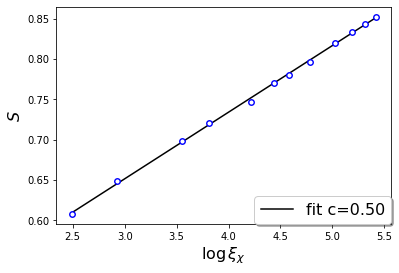

In [5]:
fit_plot_central_charge(s_list, xi_list, "central_charge_ising.pdf")